In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
# from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import resample
from keras.optimizers.legacy import Adam

In [18]:
df = pd.read_csv('../../creditcard.csv')

In [19]:
legit=df[df.Class==0]
fraud = df[df.Class == 1]

In [20]:
print(legit.shape)
print(fraud.shape)

(284315, 31)
(492, 31)


In [21]:
fraud = resample(fraud, replace=True, n_samples=len(legit), random_state=42)

In [22]:
df1 = pd.concat([legit, fraud], axis=0)

In [23]:
df1['Class'].value_counts()

Class
0    284315
1    284315
Name: count, dtype: int64

In [25]:
x=df1.drop(['Class','Time'],axis=1)
y=df1['Class']

In [26]:
print(len(x))
print(len(y))

568630
568630


In [27]:
print(x.iloc[0])

V1         -1.359807
V2         -0.072781
V3          2.536347
V4          1.378155
V5         -0.338321
V6          0.462388
V7          0.239599
V8          0.098698
V9          0.363787
V10         0.090794
V11        -0.551600
V12        -0.617801
V13        -0.991390
V14        -0.311169
V15         1.468177
V16        -0.470401
V17         0.207971
V18         0.025791
V19         0.403993
V20         0.251412
V21        -0.018307
V22         0.277838
V23        -0.110474
V24         0.066928
V25         0.128539
V26        -0.189115
V27         0.133558
V28        -0.021053
Amount    149.620000
Name: 0, dtype: float64


In [28]:
scaler=MinMaxScaler(feature_range=(0,1))

In [29]:
x=scaler.fit_transform(x)

In [30]:
print(len(x))
print(len(y))

568630
568630


In [31]:
print(x[0])

[0.93519234 0.76649042 0.8813649  0.31302266 0.76343873 0.26766864
 0.26681518 0.7864442  0.47531173 0.51060048 0.25248432 0.68090763
 0.3715906  0.63559053 0.4460837  0.43439239 0.73717255 0.65506586
 0.59486323 0.58294223 0.56118439 0.52299212 0.66379298 0.39125268
 0.58512179 0.39455679 0.41897614 0.31269663 0.00582379]


In [32]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [33]:
y_train.value_counts()

Class
0    213300
1    213172
Name: count, dtype: int64

In [34]:
y_test.value_counts()

Class
1    71143
0    71015
Name: count, dtype: int64

In [35]:
print(x_train.shape,y_train.shape)

(426472, 29) (426472,)


In [36]:
print(x_test.shape,y_test.shape)

(142158, 29) (142158,)


In [37]:
r,c=x_train.shape
x_train=x_train.reshape(r,c,1)

In [40]:
model = Sequential()
model.add(LSTM(100, input_shape=(x_train.shape[1], 1), activation='relu', return_sequences=True))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

INIT_LR = 1e-5
epc=1
bs=200
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / epc)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 29, 100)           40800     
                                                                 
 lstm_5 (LSTM)               (None, 29, 100)           80400     
                                                                 
 lstm_6 (LSTM)               (None, 29, 100)           80400     
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 231851 (905.67 KB)
Trainable params: 231851 (905.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [41]:
modelfit=model.fit(x_train,y_train,epochs=epc,batch_size=bs,verbose=1)

2133/2133 [==============================] - 988s 458ms/step - loss: 0.2058 - accuracy: 0.9182


In [42]:
model.save("LSTM_Upsampling_model.keras")

In [45]:
y_train_pred=model.predict(x_train)

13328/13328 [==============================] - 241s 18ms/step


In [46]:
y_train_pred=(y_train_pred>0.5).astype(int)

In [47]:
print("Accuracy on Training Data : ",accuracy_score(y_train,y_train_pred))

Accuracy on Training Data :  0.9406291620551877


In [48]:
print("Classification Report :\n",classification_report(y_train_pred,y_train))

Classification Report :
               precision    recall  f1-score   support

           0       0.98      0.91      0.94    229294
           1       0.90      0.98      0.94    197178

    accuracy                           0.94    426472
   macro avg       0.94      0.94      0.94    426472
weighted avg       0.94      0.94      0.94    426472



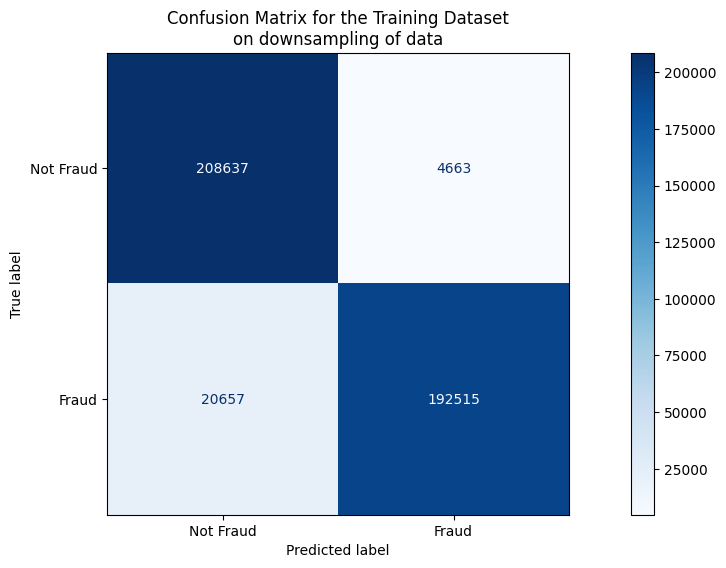

In [49]:
cm = confusion_matrix(y_train, y_train_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for the Training Dataset\non upsampling of data')
plt.show();